## TESTES

TensorFlow Lite Model Benchmark
TensorFlow version: 2.19.0
Number of runs per model: 100
Model: mobilenetv3.tflite
Input shape: [  1 224 224   3]
Input dtype: <class 'numpy.float32'>

=== Benchmarking mobilenetv3.tflite ===
Running 10 warmup iterations...
Running 100 benchmark iterations...
  Progress: 20/100
  Progress: 40/100


c:\Users\saulo\PIBIC\TinyML\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


  Progress: 60/100
  Progress: 80/100
  Progress: 100/100

--- Results for mobilenetv3 (batch_size=1) ---
Mean latency: 3.04 ± 3.05 ms
P95 latency: 5.65 ms
P99 latency: 15.03 ms
Throughput: 328.7 FPS
Model: efficientNetB0.tflite
Input shape: [  1 224 224   3]
Input dtype: <class 'numpy.float32'>

=== Benchmarking efficientNetB0.tflite ===
Running 10 warmup iterations...
Running 100 benchmark iterations...
  Progress: 20/100
  Progress: 40/100
  Progress: 60/100
  Progress: 80/100
  Progress: 100/100

--- Results for efficientNetB0 (batch_size=1) ---
Mean latency: 20.14 ± 3.21 ms
P95 latency: 25.63 ms
P99 latency: 29.87 ms
Throughput: 49.6 FPS
Model: lcnn.tflite
Input shape: [  1 224 224   3]
Input dtype: <class 'numpy.float32'>

=== Benchmarking lcnn.tflite ===
Running 10 warmup iterations...
Running 100 benchmark iterations...
  Progress: 20/100
  Progress: 40/100
  Progress: 60/100
  Progress: 80/100
  Progress: 100/100

--- Results for lcnn (batch_size=1) ---
Mean latency: 11.63 ± 1

C:\Users\saulo\AppData\Local\Temp\ipykernel_18788\4036303346.py:156: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax3.boxplot(latency_data, labels=df['model_name'])


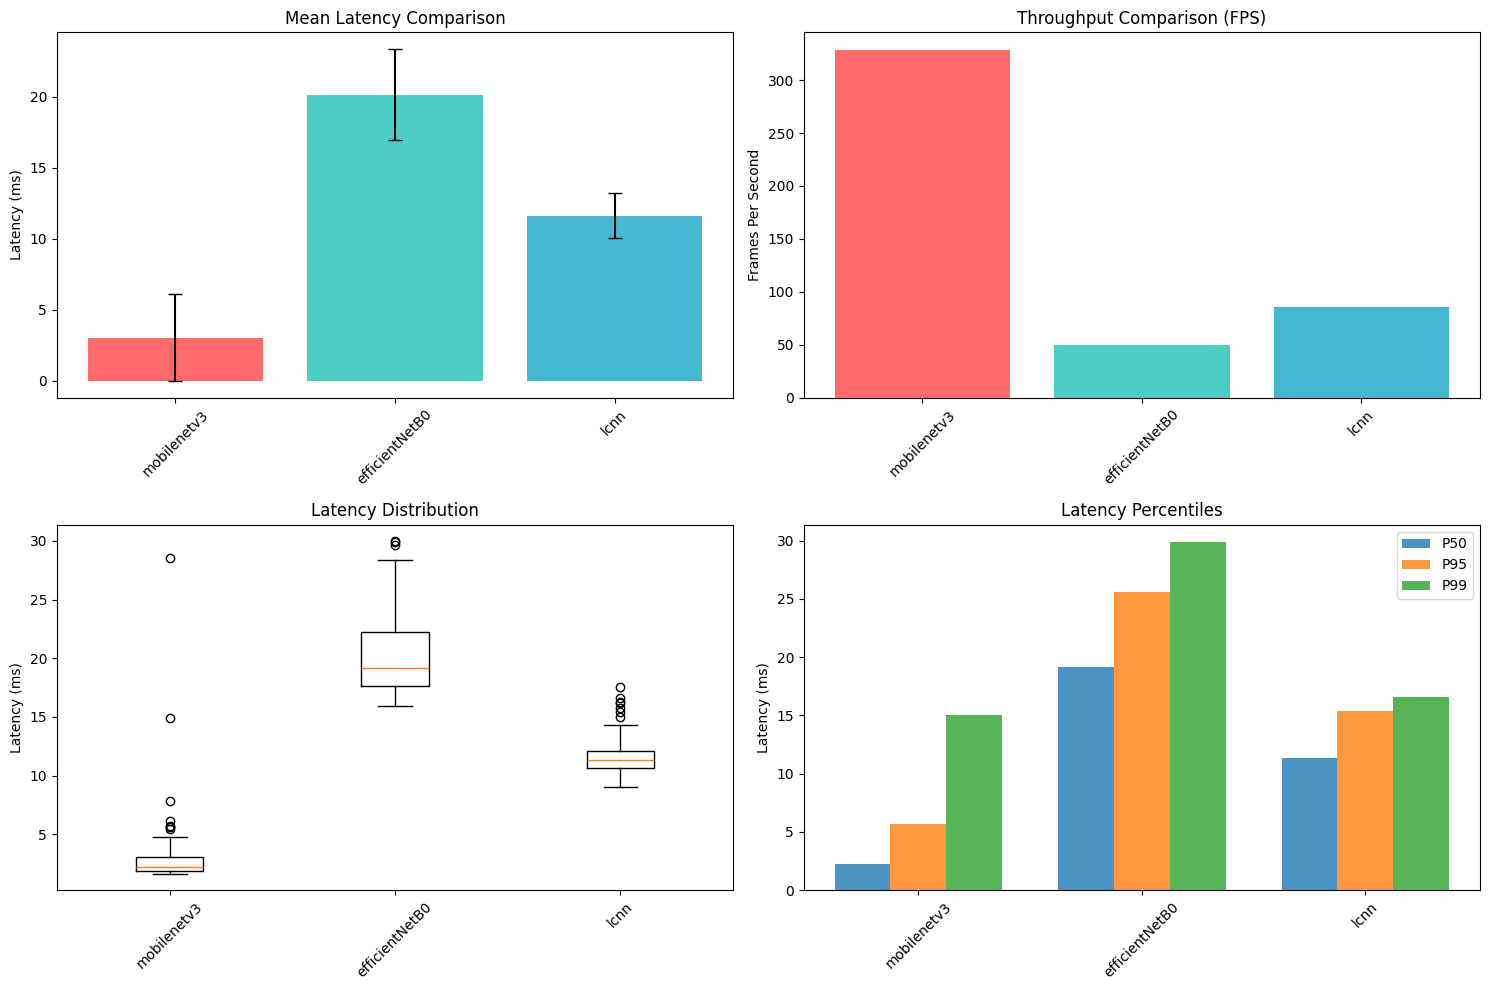

Results saved to benchmark_results.json

🏆 Best Latency: mobilenetv3 (3.04 ms)
🚀 Best Throughput: mobilenetv3 (328.7 FPS)


In [2]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import json

class TFLiteBenchmark:
    def __init__(self, model_path):
        self.model_path = model_path
        self.interpreter = tf.lite.Interpreter(model_path=str(model_path))
        self.interpreter.allocate_tensors()
        
        # Get input and output details
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        
        # Get input shape
        self.input_shape = self.input_details[0]['shape']
        print(f"Model: {model_path.name}")
        print(f"Input shape: {self.input_shape}")
        print(f"Input dtype: {self.input_details[0]['dtype']}")
        
    def create_sample_input(self, batch_size=1):
        """Create random input data matching model requirements"""
        shape = self.input_shape.copy()
        if shape[0] == 1 or shape[0] == -1:  # Dynamic batch size
            shape[0] = batch_size
        
        # Generate random data in range [0, 1] for image models
        if self.input_details[0]['dtype'] == np.float32:
            return np.random.random(shape).astype(np.float32)
        elif self.input_details[0]['dtype'] == np.uint8:
            return np.random.randint(0, 256, shape, dtype=np.uint8)
        else:
            return np.random.random(shape).astype(self.input_details[0]['dtype'])
    
    def single_inference(self, input_data):
        """Run single inference and return latency"""
        start_time = time.perf_counter()
        
        # Set input tensor
        self.interpreter.set_tensor(self.input_details[0]['index'], input_data)
        
        # Run inference
        self.interpreter.invoke()
        
        # Get output
        output = self.interpreter.get_tensor(self.output_details[0]['index'])
        
        end_time = time.perf_counter()
        return end_time - start_time, output
    
    def benchmark(self, num_warmup=10, num_runs=100, batch_size=1):
        """Run comprehensive benchmark"""
        print(f"\n=== Benchmarking {self.model_path.name} ===")
        
        # Create sample input
        sample_input = self.create_sample_input(batch_size)
        
        # Warmup runs
        print(f"Running {num_warmup} warmup iterations...")
        for _ in range(num_warmup):
            _, _ = self.single_inference(sample_input)
        
        # Actual benchmark runs
        print(f"Running {num_runs} benchmark iterations...")
        latencies = []
        
        for i in range(num_runs):
            if (i + 1) % 20 == 0:
                print(f"  Progress: {i + 1}/{num_runs}")
            
            latency, _ = self.single_inference(sample_input)
            latencies.append(latency * 1000)  # Convert to milliseconds
        
        # Calculate statistics
        stats = {
            'model_name': self.model_path.stem,
            'num_runs': num_runs,
            'mean_ms': np.mean(latencies),
            'std_ms': np.std(latencies),
            'min_ms': np.min(latencies),
            'max_ms': np.max(latencies),
            'p50_ms': np.percentile(latencies, 50),
            'p95_ms': np.percentile(latencies, 95),
            'p99_ms': np.percentile(latencies, 99),
            'fps': 1000 / np.mean(latencies),
            'input_shape': self.input_shape.tolist(),
            'batch_size': batch_size
        }
        
        return stats, latencies

def compare_models(model_paths, num_runs=100, batch_sizes=[1]):
    """Compare multiple TFLite models"""
    all_results = []
    all_latencies = {}
    
    for model_path in model_paths:
        if not Path(model_path).exists():
            print(f"Warning: Model {model_path} not found!")
            continue
            
        benchmark = TFLiteBenchmark(Path(model_path))
        
        for batch_size in batch_sizes:
            try:
                stats, latencies = benchmark.benchmark(num_runs=num_runs, batch_size=batch_size)
                all_results.append(stats)
                all_latencies[f"{stats['model_name']}_batch{batch_size}"] = latencies
                
                # Print results
                print(f"\n--- Results for {stats['model_name']} (batch_size={batch_size}) ---")
                print(f"Mean latency: {stats['mean_ms']:.2f} ± {stats['std_ms']:.2f} ms")
                print(f"P95 latency: {stats['p95_ms']:.2f} ms")
                print(f"P99 latency: {stats['p99_ms']:.2f} ms")
                print(f"Throughput: {stats['fps']:.1f} FPS")
                
            except Exception as e:
                print(f"Error benchmarking {model_path}: {e}")
    
    return all_results, all_latencies

def create_visualizations(results, latencies):
    """Create visualization plots"""
    if not results:
        print("No results to visualize!")
        return
    
    df = pd.DataFrame(results)
    
    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Mean Latency Comparison
    ax1.bar(df['model_name'], df['mean_ms'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax1.set_title('Mean Latency Comparison')
    ax1.set_ylabel('Latency (ms)')
    ax1.tick_params(axis='x', rotation=45)
    
    # Add error bars
    ax1.errorbar(df['model_name'], df['mean_ms'], yerr=df['std_ms'], 
                fmt='none', color='black', capsize=5)
    
    # 2. Throughput Comparison
    ax2.bar(df['model_name'], df['fps'], color=['#FF6B6B', '#4ECDC4', '#45B7D1'])
    ax2.set_title('Throughput Comparison (FPS)')
    ax2.set_ylabel('Frames Per Second')
    ax2.tick_params(axis='x', rotation=45)
    
    # 3. Latency Distribution (Box Plot)
    latency_data = [latencies[f"{name}_batch1"] for name in df['model_name'] 
                   if f"{name}_batch1" in latencies]
    ax3.boxplot(latency_data, labels=df['model_name'])
    ax3.set_title('Latency Distribution')
    ax3.set_ylabel('Latency (ms)')
    ax3.tick_params(axis='x', rotation=45)
    
    # 4. Percentile Comparison
    metrics = ['p50_ms', 'p95_ms', 'p99_ms']
    x = np.arange(len(df['model_name']))
    width = 0.25
    
    for i, metric in enumerate(metrics):
        ax4.bar(x + i*width, df[metric], width, 
                label=f'P{metric[1:3]}', alpha=0.8)
    
    ax4.set_title('Latency Percentiles')
    ax4.set_ylabel('Latency (ms)')
    ax4.set_xticks(x + width)
    ax4.set_xticklabels(df['model_name'], rotation=45)
    ax4.legend()
    
    plt.tight_layout()
    plt.savefig('tflite_benchmark_results.png', dpi=300, bbox_inches='tight')
    plt.show()

def save_results(results, filename='benchmark_results.json'):
    """Save results to JSON file"""
    with open(filename, 'w') as f:
        json.dump(results, f, indent=2)
    print(f"Results saved to {filename}")

# Main execution
if __name__ == "__main__":
    # Specify your model paths here
    model_paths = [
        "models/compressed/mobilenetv3.tflite",           # Substitua pelo caminho real
        "models/compressed/efficientNetB0.tflite",       # Substitua pelo caminho real  
        "models/compressed/lcnn.tflite"                  # Substitua pelo caminho real
    ]
    
    print("TensorFlow Lite Model Benchmark")
    print("=====================================")
    print(f"TensorFlow version: {tf.__version__}")
    print(f"Number of runs per model: 100")
    
    # Run benchmarks
    results, latencies = compare_models(
        model_paths=model_paths,
        num_runs=100,
        batch_sizes=[1]  # You can test multiple batch sizes: [1, 4, 8]
    )
    
    if results:
        # Create summary table
        df = pd.DataFrame(results)
        print("\n" + "="*80)
        print("SUMMARY RESULTS")
        print("="*80)
        print(df[['model_name', 'mean_ms', 'p95_ms', 'fps']].to_string(index=False))
        
        # Create visualizations
        create_visualizations(results, latencies)
        
        # Save results
        save_results(results)
        
        # Find best model
        best_latency = df.loc[df['mean_ms'].idxmin()]
        best_throughput = df.loc[df['fps'].idxmax()]
        
        print(f"\n🏆 Best Latency: {best_latency['model_name']} ({best_latency['mean_ms']:.2f} ms)")
        print(f"🚀 Best Throughput: {best_throughput['model_name']} ({best_throughput['fps']:.1f} FPS)")
    
    else:
        print("No models were successfully benchmarked. Please check your model paths.")

🥭 Benchmark TFLite com Dataset MangoLeaf

=== Benchmarking mobilenetv3.tflite com dataset real ===
Carregando imagens de MangoLeaf
  Anthracnose: 500 imagens
  Healthy: 500 imagens
Total de imagens selecionadas: 110
Preprocessando imagens...


c:\Users\saulo\PIBIC\TinyML\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Distribuição das classes no benchmark:
  Anthracnose: 53 imagens
  Healthy: 57 imagens
Executando 10 warmup runs...
Executando 100 benchmark runs...
  Progress: 20/100
  Progress: 40/100
  Progress: 60/100
  Progress: 80/100
  Progress: 100/100

--- Resultados para mobilenetv3 ---
Dataset: MangoLeaf_Real_Data
Latência média: 2.41 ± 0.74 ms
P95 latência: 4.08 ms
Throughput: 414.4 FPS

=== Benchmarking efficientNetB0.tflite com dataset real ===
Carregando imagens de MangoLeaf
  Anthracnose: 500 imagens
  Healthy: 500 imagens
Total de imagens selecionadas: 110
Preprocessando imagens...
Distribuição das classes no benchmark:
  Healthy: 61 imagens
  Anthracnose: 49 imagens
Executando 10 warmup runs...
Executando 100 benchmark runs...
  Progress: 20/100
  Progress: 40/100
  Progress: 60/100
  Progress: 80/100
  Progress: 100/100

--- Resultados para efficientNetB0 ---
Dataset: MangoLeaf_Real_Data
Latência média: 19.69 ± 3.06 ms
P95 latência: 26.85 ms
Throughput: 50.8 FPS

=== Benchmarking lc

C:\Users\saulo\AppData\Local\Temp\ipykernel_18788\372524203.py:197: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(latency_data, labels=model_names, patch_artist=True,


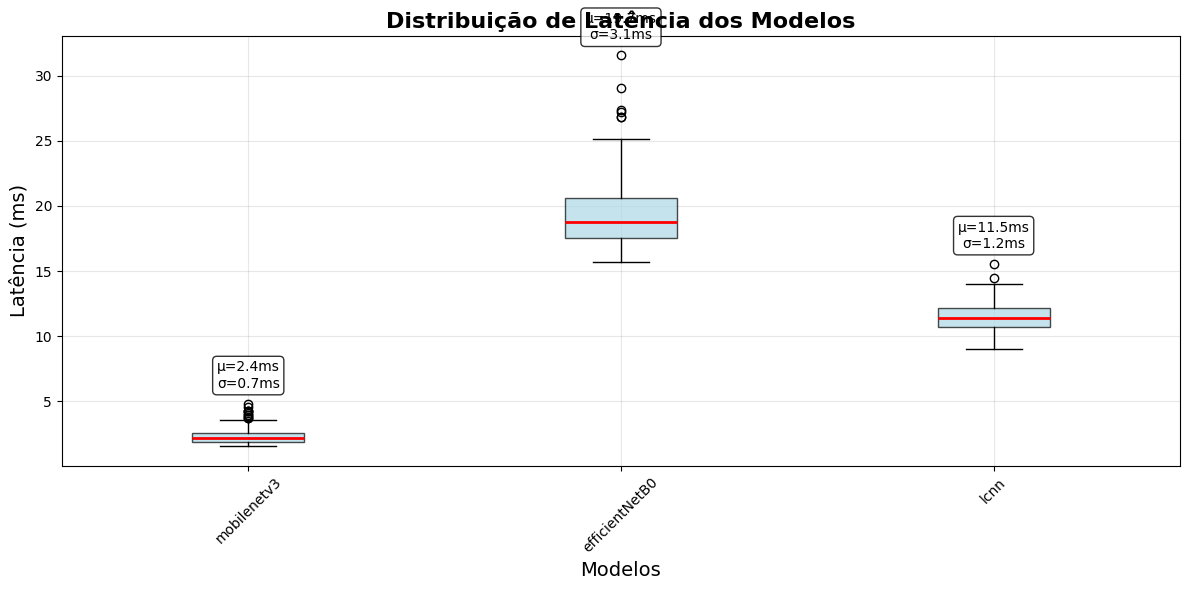

📊 Gráfico de distribuição de latência salvo como 'latency_distribution.png'


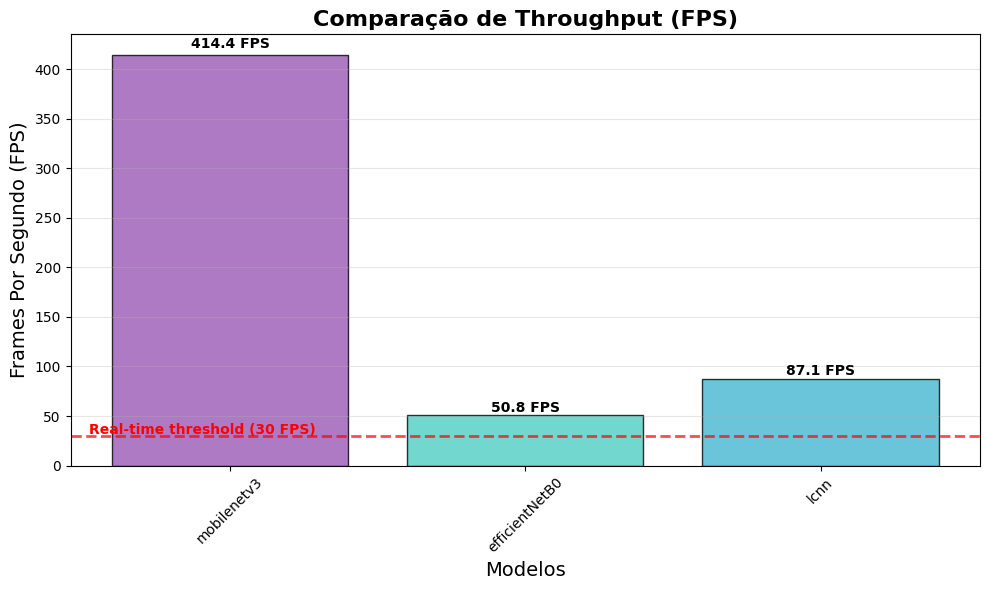

🚀 Gráfico de comparação de FPS salvo como 'fps_comparison.png'


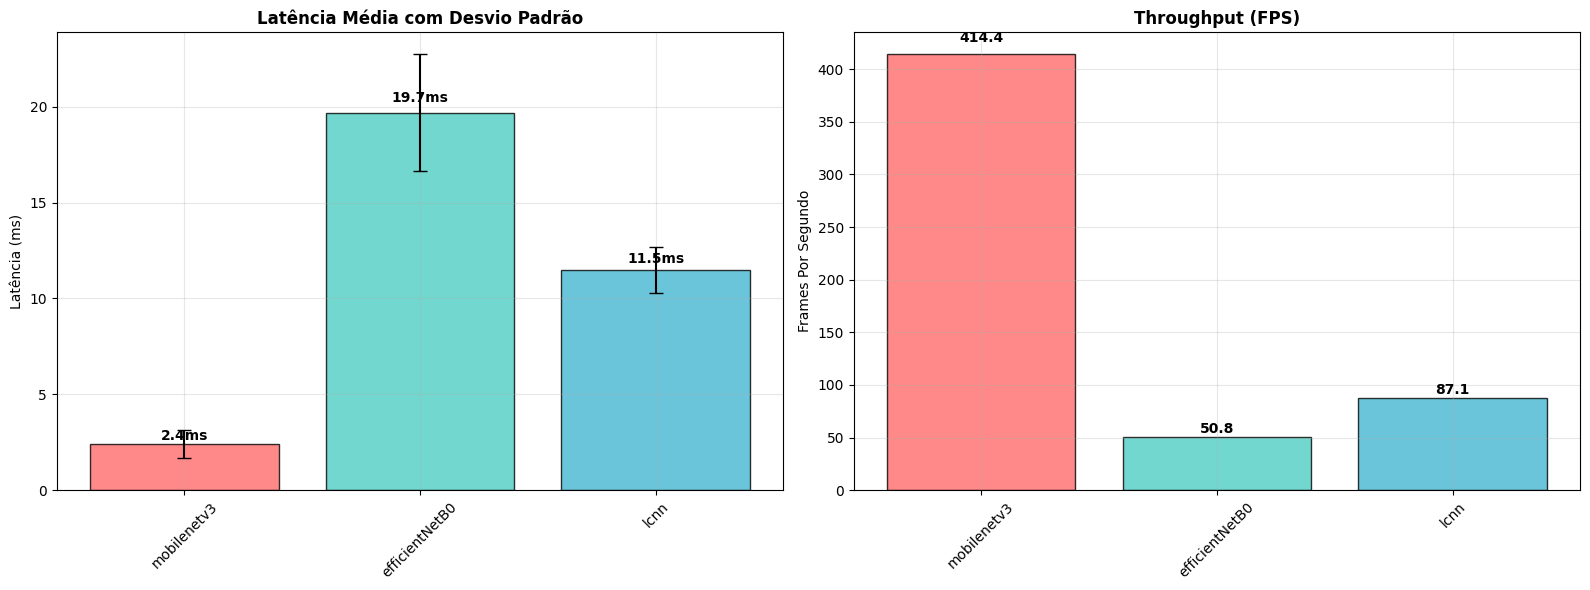

📊 Gráfico combinado salvo como 'combined_benchmark_results.png'


In [10]:
import tensorflow as tf
import numpy as np
import time
import cv2
import os
from pathlib import Path
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class TFLiteBenchmarkWithDataset:
    def __init__(self, model_path):
        self.model_path = model_path
        self.interpreter = tf.lite.Interpreter(model_path=str(model_path))
        self.interpreter.allocate_tensors()
        
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        self.input_shape = self.input_details[0]['shape']
        
    def load_dataset_images(self, dataset_path, num_samples=100):
        """Carrega imagens do dataset MangoLeaf"""
        dataset_path = Path(dataset_path)
        all_images = []
        
        # Classes esperadas (ajuste conforme necessário)
        classes = ['Anthracnose', 'Bacterial_Canker', 'Cutting_Weevil', 
                  'Die_Back', 'Gall_Midge', 'Healthy', 'Powdery_Mildew', 'Sooty_Mould']
        
        print(f"Carregando imagens de {dataset_path}")
        
        for class_name in classes:
            class_path = dataset_path / class_name
            if class_path.exists():
                # Pegar todas as imagens da classe
                image_files = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png'))
                all_images.extend([(img_path, class_name) for img_path in image_files])
                print(f"  {class_name}: {len(image_files)} imagens")
        
        # Embaralhar e pegar amostra
        random.shuffle(all_images)
        selected_images = all_images[:min(num_samples, len(all_images))]
        
        print(f"Total de imagens selecionadas: {len(selected_images)}")
        return selected_images
    
    def preprocess_image(self, image_path):
        """Preprocessa imagem para o modelo"""
        try:
            # Carregar imagem
            img = cv2.imread(str(image_path))
            if img is None:
                return None
                
            # Converter BGR para RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Redimensionar para input do modelo
            target_size = (self.input_shape[1], self.input_shape[2])  # (height, width)
            img = cv2.resize(img, target_size)
            
            # Normalizar
            if self.input_details[0]['dtype'] == np.float32:
                img = img.astype(np.float32) / 255.0
            else:
                img = img.astype(np.uint8)
            
            # Adicionar batch dimension
            img = np.expand_dims(img, axis=0)
            
            return img
            
        except Exception as e:
            print(f"Erro ao processar {image_path}: {e}")
            return None
    
    def single_inference(self, input_data):
        """Run single inference and return latency"""
        start_time = time.perf_counter()
        
        self.interpreter.set_tensor(self.input_details[0]['index'], input_data)
        self.interpreter.invoke()
        output = self.interpreter.get_tensor(self.output_details[0]['index'])
        
        end_time = time.perf_counter()
        return end_time - start_time, output
    
    def benchmark_with_real_data(self, dataset_path, num_warmup=10, num_runs=100):
        """Benchmark usando dataset real de manga"""
        print(f"\n=== Benchmarking {self.model_path.name} com dataset real ===")
        
        # Carregar imagens
        selected_images = self.load_dataset_images(dataset_path, num_runs + num_warmup)
        
        if len(selected_images) < num_runs:
            print(f"⚠️  Apenas {len(selected_images)} imagens disponíveis, ajustando num_runs")
            num_runs = len(selected_images) - num_warmup
        
        # Preprocessar todas as imagens
        preprocessed_images = []
        class_distribution = defaultdict(int)
        
        print("Preprocessando imagens...")
        for img_path, class_name in selected_images:
            processed_img = self.preprocess_image(img_path)
            if processed_img is not None:
                preprocessed_images.append((processed_img, class_name))
                class_distribution[class_name] += 1
        
        print("Distribuição das classes no benchmark:")
        for class_name, count in class_distribution.items():
            print(f"  {class_name}: {count} imagens")
        
        # Warmup
        print(f"Executando {num_warmup} warmup runs...")
        for i in range(num_warmup):
            img, _ = preprocessed_images[i]
            _, _ = self.single_inference(img)
        
        # Benchmark real
        print(f"Executando {num_runs} benchmark runs...")
        latencies = []
        
        for i in range(num_warmup, num_warmup + num_runs):
            if (i - num_warmup + 1) % 20 == 0:
                print(f"  Progress: {i - num_warmup + 1}/{num_runs}")
            
            img, class_name = preprocessed_images[i]
            latency, _ = self.single_inference(img)
            latencies.append(latency * 1000)  # Convert to ms
        
        # Calcular estatísticas
        stats = {
            'model_name': self.model_path.stem,
            'dataset_used': 'MangoLeaf_Real_Data',
            'num_runs': num_runs,
            'mean_ms': np.mean(latencies),
            'std_ms': np.std(latencies),
            'min_ms': np.min(latencies),
            'max_ms': np.max(latencies),
            'p50_ms': np.percentile(latencies, 50),
            'p95_ms': np.percentile(latencies, 95),
            'p99_ms': np.percentile(latencies, 99),
            'fps': 1000 / np.mean(latencies),
            'input_shape': self.input_shape.tolist(),
            'class_distribution': dict(class_distribution)
        }
        
        return stats, latencies

def benchmark_mango_models(model_paths, dataset_path, num_runs=100):
    """Benchmark múltiplos modelos com dataset de manga"""
    all_results = []
    all_latencies = {}
    
    for model_path in model_paths:
        if not Path(model_path).exists():
            print(f"⚠️  Modelo {model_path} não encontrado!")
            continue
            
        try:
            benchmark = TFLiteBenchmarkWithDataset(Path(model_path))
            stats, latencies = benchmark.benchmark_with_real_data(dataset_path, num_runs=num_runs)
            
            all_results.append(stats)
            all_latencies[stats['model_name']] = latencies
            
            # Print results
            print(f"\n--- Resultados para {stats['model_name']} ---")
            print(f"Dataset: {stats['dataset_used']}")
            print(f"Latência média: {stats['mean_ms']:.2f} ± {stats['std_ms']:.2f} ms")
            print(f"P95 latência: {stats['p95_ms']:.2f} ms")
            print(f"Throughput: {stats['fps']:.1f} FPS")
            
        except Exception as e:
            print(f"Erro no benchmark de {model_path}: {e}")
    
    return all_results, all_latencies

def plot_latency_distribution(results, latencies):
    """Plota a distribuição de latência"""
    plt.figure(figsize=(12, 6))
    
    # Preparar dados para o boxplot
    latency_data = []
    model_names = []
    
    for result in results:
        model_name = result['model_name']
        if model_name in latencies:
            latency_data.append(latencies[model_name])
            model_names.append(model_name)
    
    # Criar boxplot
    plt.boxplot(latency_data, labels=model_names, patch_artist=True, 
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
    
    plt.title('Distribuição de Latência dos Modelos', fontsize=16, fontweight='bold')
    plt.ylabel('Latência (ms)', fontsize=14)
    plt.xlabel('Modelos', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    # Adicionar estatísticas no gráfico
    for i, result in enumerate(results):
        if result['model_name'] in latencies:
            plt.text(i+1, result['max_ms'] + 1, 
                    f"μ={result['mean_ms']:.1f}ms\nσ={result['std_ms']:.1f}ms", 
                    ha='center', va='bottom', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('latency_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("📊 Gráfico de distribuição de latência salvo como 'latency_distribution.png'")

def plot_fps_comparison(results):
    """Plota comparação de FPS"""
    plt.figure(figsize=(10, 6))
    
    # Extrair dados
    model_names = [result['model_name'] for result in results]
    fps_values = [result['fps'] for result in results]
    
    # Cores diferentes para cada modelo
    colors = ['#9B59B6', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'][:len(model_names)]
    
    # Criar gráfico de barras
    bars = plt.bar(model_names, fps_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    
    plt.title('Comparação de Throughput (FPS)', fontsize=16, fontweight='bold')
    plt.ylabel('Frames Por Segundo (FPS)', fontsize=14)
    plt.xlabel('Modelos', fontsize=14)
    plt.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=45)
    
    # Adicionar valores nas barras
    for bar, fps in zip(bars, fps_values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{fps:.1f} FPS', ha='center', va='bottom', fontweight='bold')
    
    # Adicionar linha de referência para tempo real (30 FPS)
    plt.axhline(y=30, color='red', linestyle='--', alpha=0.7, linewidth=2)
    plt.text(0.02, 32, 'Real-time threshold (30 FPS)', transform=plt.gca().get_yaxis_transform(),
             color='red', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('fps_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("🚀 Gráfico de comparação de FPS salvo como 'fps_comparison.png'")

def create_comprehensive_plots(results, latencies):
    """Cria todos os gráficos de uma vez"""
    print("\n📈 Gerando visualizações...")
    
    # 1. Distribuição de Latência
    plot_latency_distribution(results, latencies)
    
    # 2. Comparação de FPS
    plot_fps_comparison(results)
    
    # 3. Gráfico combinado (opcional)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Subplot 1: Latência média com erro
    model_names = [result['model_name'] for result in results]
    mean_latencies = [result['mean_ms'] for result in results]
    std_latencies = [result['std_ms'] for result in results]
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1'][:len(model_names)]
    bars1 = ax1.bar(model_names, mean_latencies, yerr=std_latencies, 
                    capsize=5, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('Latência Média com Desvio Padrão', fontweight='bold')
    ax1.set_ylabel('Latência (ms)')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Subplot 2: FPS
    fps_values = [result['fps'] for result in results]
    bars2 = ax2.bar(model_names, fps_values, color=colors, alpha=0.8, edgecolor='black')
    ax2.set_title('Throughput (FPS)', fontweight='bold')
    ax2.set_ylabel('Frames Por Segundo')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # Adicionar valores nas barras
    for bar, value in zip(bars1, mean_latencies):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + bar.get_height()*0.02,
                f'{value:.1f}ms', ha='center', va='bottom', fontweight='bold')
    
    for bar, value in zip(bars2, fps_values):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + bar.get_height()*0.02,
                f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('combined_benchmark_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("📊 Gráfico combinado salvo como 'combined_benchmark_results.png'")

# Uso principal
if __name__ == "__main__":
    # Seus caminhos
    model_paths = [
        "models/compressed/mobilenetv3.tflite",
        "models/compressed/efficientNetB0.tflite", 
        "models/compressed/lcnn.tflite"
    ]
    
    # Caminho do seu dataset
    dataset_path = "MangoLeaf"  # Ajuste para o caminho correto
    
    print("🥭 Benchmark TFLite com Dataset MangoLeaf")
    print("=" * 50)
    
    # Executar benchmark
    results, latencies = benchmark_mango_models(
        model_paths=model_paths,
        dataset_path=dataset_path,
        num_runs=100
    )
    
    # Criar relatório
    if results:
        print("\n" + "="*60)
        print("📊 RELATÓRIO FINAL")
        print("="*60)
        
        for result in results:
            print(f"\n🤖 {result['model_name']}:")
            print(f"   Latência: {result['mean_ms']:.2f}ms (±{result['std_ms']:.2f})")
            print(f"   FPS: {result['fps']:.1f}")
            print(f"   P95: {result['p95_ms']:.2f}ms")
        
        # Gerar todas as visualizações
        create_comprehensive_plots(results, latencies)
    
    else:
        print("❌ Nenhum modelo foi benchmarkado com sucesso. Verifique os caminhos dos modelos.")

🥭 Benchmark TFLite com Dataset MangoLeaf

=== Benchmarking mobilenetv3.tflite com dataset real ===
Carregando imagens de MangoLeaf
  Anthracnose: 500 imagens
  Healthy: 500 imagens
Total de imagens selecionadas: 110
Preprocessando imagens...


c:\Users\saulo\PIBIC\TinyML\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Distribuição das classes no benchmark:
  Healthy: 54 imagens
  Anthracnose: 56 imagens
Executando 10 warmup runs...
Executando 100 benchmark runs...
  Progress: 20/100
  Progress: 40/100
  Progress: 60/100
  Progress: 80/100
  Progress: 100/100

--- Resultados para mobilenetv3 ---
Dataset: MangoLeaf_Real_Data
Latência média: 2.21 ± 0.66 ms
P95 latência: 3.68 ms
Throughput: 452.3 FPS

=== Benchmarking efficientNetB0.tflite com dataset real ===
Carregando imagens de MangoLeaf
  Anthracnose: 500 imagens
  Healthy: 500 imagens
Total de imagens selecionadas: 110
Preprocessando imagens...
Distribuição das classes no benchmark:
  Anthracnose: 57 imagens
  Healthy: 53 imagens
Executando 10 warmup runs...
Executando 100 benchmark runs...
  Progress: 20/100
  Progress: 40/100
  Progress: 60/100
  Progress: 80/100
  Progress: 100/100

--- Resultados para efficientNetB0 ---
Dataset: MangoLeaf_Real_Data
Latência média: 17.93 ± 2.54 ms
P95 latência: 23.05 ms
Throughput: 55.8 FPS

=== Benchmarking lc

C:\Users\saulo\AppData\Local\Temp\ipykernel_3184\2930973832.py:197: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(latency_data, labels=model_names, patch_artist=True,


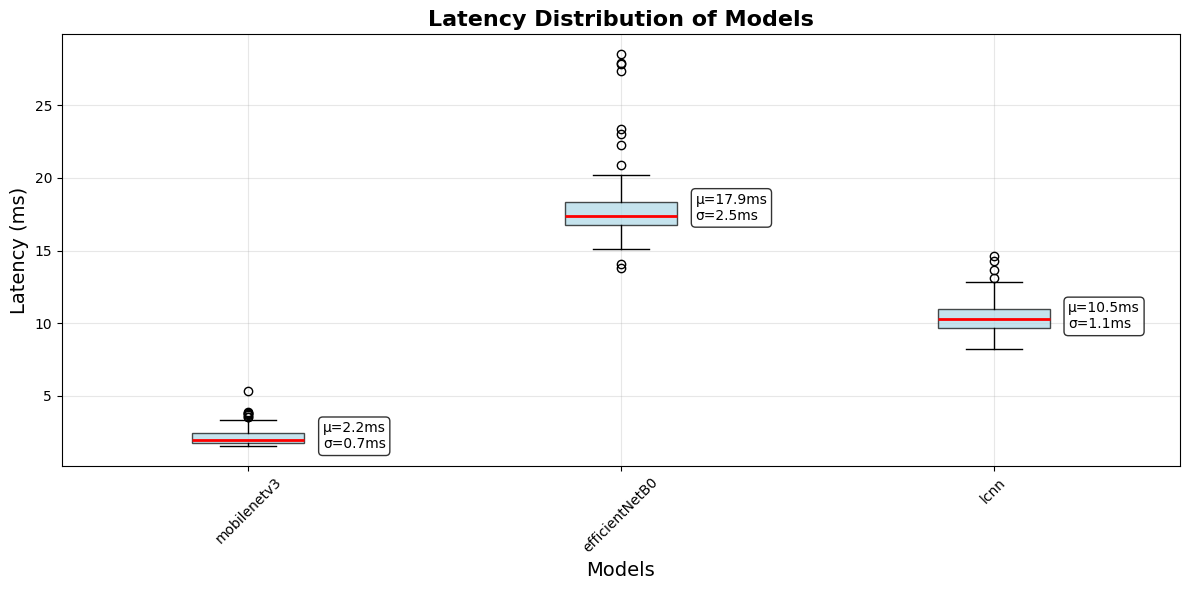

📊 Gráfico de distribuição de latência salvo como 'latency_distribution.png'


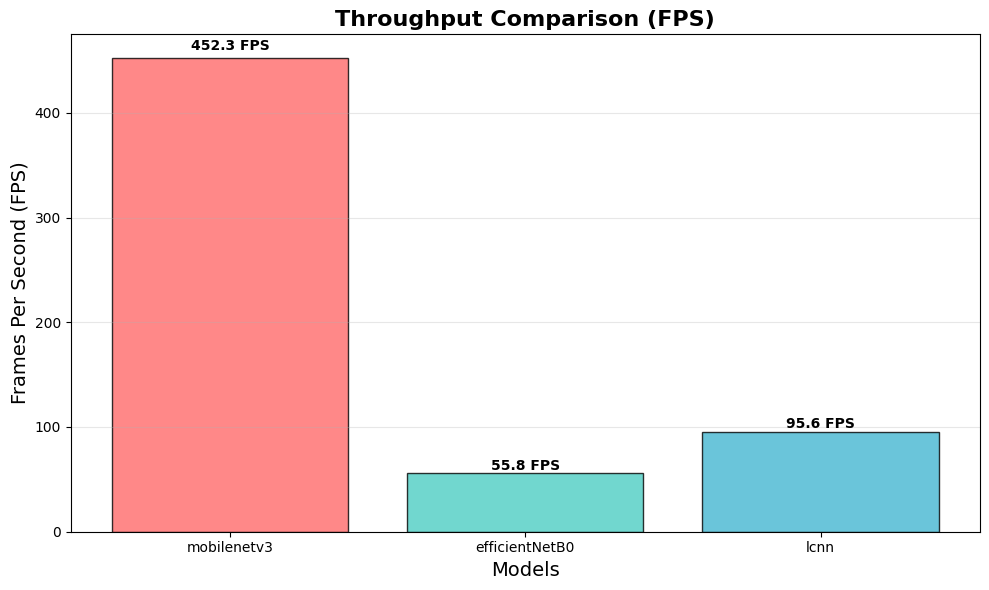

🚀 Gráfico de comparação de FPS salvo como 'fps_comparison.png'


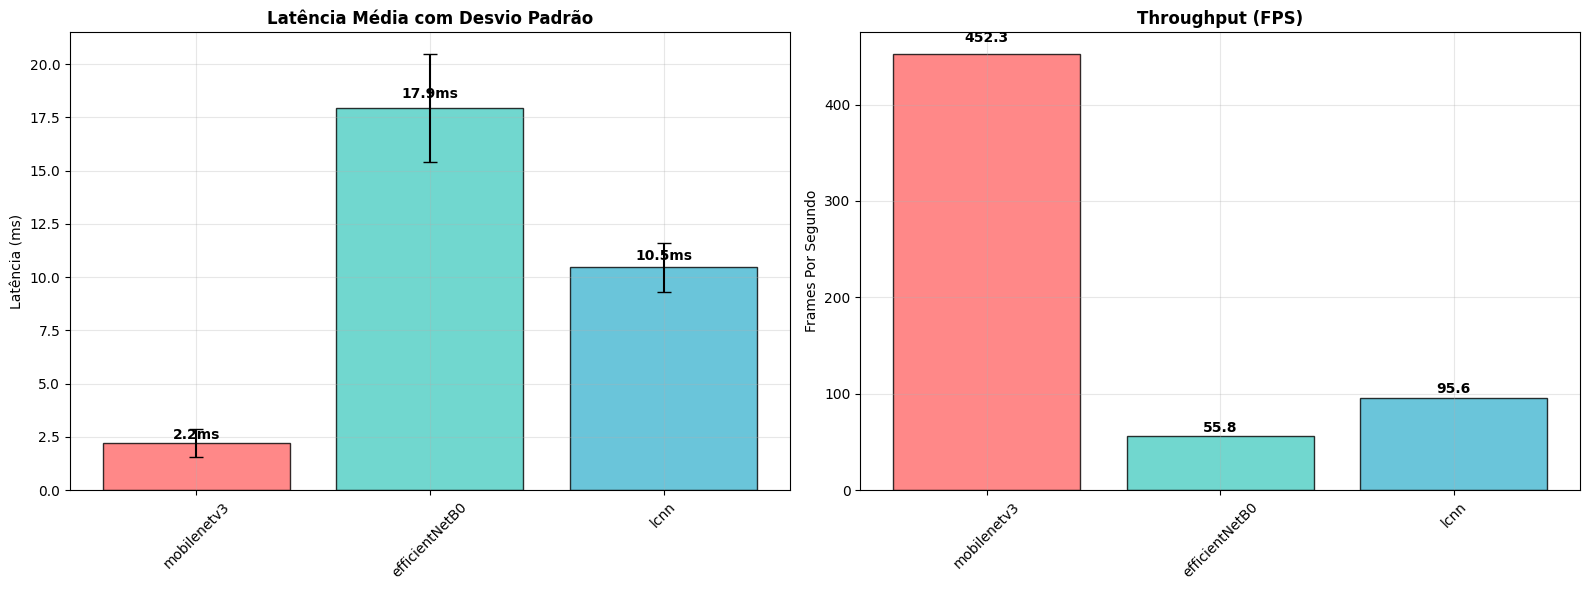

📊 Gráfico combinado salvo como 'combined_benchmark_results.png'


In [4]:
import tensorflow as tf
import numpy as np
import time
import cv2
import os
from pathlib import Path
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

class TFLiteBenchmarkWithDataset:
    def __init__(self, model_path):
        self.model_path = model_path
        self.interpreter = tf.lite.Interpreter(model_path=str(model_path))
        self.interpreter.allocate_tensors()
        
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        self.input_shape = self.input_details[0]['shape']
        
    def load_dataset_images(self, dataset_path, num_samples=100):
        """Carrega imagens do dataset MangoLeaf"""
        dataset_path = Path(dataset_path)
        all_images = []
        
        # Classes esperadas (ajuste conforme necessário)
        classes = ['Anthracnose', 'Bacterial_Canker', 'Cutting_Weevil', 
                  'Die_Back', 'Gall_Midge', 'Healthy', 'Powdery_Mildew', 'Sooty_Mould']
        
        print(f"Carregando imagens de {dataset_path}")
        
        for class_name in classes:
            class_path = dataset_path / class_name
            if class_path.exists():
                # Pegar todas as imagens da classe
                image_files = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png'))
                all_images.extend([(img_path, class_name) for img_path in image_files])
                print(f"  {class_name}: {len(image_files)} imagens")
        
        # Embaralhar e pegar amostra
        random.shuffle(all_images)
        selected_images = all_images[:min(num_samples, len(all_images))]
        
        print(f"Total de imagens selecionadas: {len(selected_images)}")
        return selected_images
    
    def preprocess_image(self, image_path):
        """Preprocessa imagem para o modelo"""
        try:
            # Carregar imagem
            img = cv2.imread(str(image_path))
            if img is None:
                return None
                
            # Converter BGR para RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Redimensionar para input do modelo
            target_size = (self.input_shape[1], self.input_shape[2])  # (height, width)
            img = cv2.resize(img, target_size)
            
            # Normalizar
            if self.input_details[0]['dtype'] == np.float32:
                img = img.astype(np.float32) / 255.0
            else:
                img = img.astype(np.uint8)
            
            # Adicionar batch dimension
            img = np.expand_dims(img, axis=0)
            
            return img
            
        except Exception as e:
            print(f"Erro ao processar {image_path}: {e}")
            return None
    
    def single_inference(self, input_data):
        """Run single inference and return latency"""
        start_time = time.perf_counter()
        
        self.interpreter.set_tensor(self.input_details[0]['index'], input_data)
        self.interpreter.invoke()
        output = self.interpreter.get_tensor(self.output_details[0]['index'])
        
        end_time = time.perf_counter()
        return end_time - start_time, output
    
    def benchmark_with_real_data(self, dataset_path, num_warmup=10, num_runs=100):
        """Benchmark usando dataset real de manga"""
        print(f"\n=== Benchmarking {self.model_path.name} com dataset real ===")
        
        # Carregar imagens
        selected_images = self.load_dataset_images(dataset_path, num_runs + num_warmup)
        
        if len(selected_images) < num_runs:
            print(f"⚠️  Apenas {len(selected_images)} imagens disponíveis, ajustando num_runs")
            num_runs = len(selected_images) - num_warmup
        
        # Preprocessar todas as imagens
        preprocessed_images = []
        class_distribution = defaultdict(int)
        
        print("Preprocessando imagens...")
        for img_path, class_name in selected_images:
            processed_img = self.preprocess_image(img_path)
            if processed_img is not None:
                preprocessed_images.append((processed_img, class_name))
                class_distribution[class_name] += 1
        
        print("Distribuição das classes no benchmark:")
        for class_name, count in class_distribution.items():
            print(f"  {class_name}: {count} imagens")
        
        # Warmup
        print(f"Executando {num_warmup} warmup runs...")
        for i in range(num_warmup):
            img, _ = preprocessed_images[i]
            _, _ = self.single_inference(img)
        
        # Benchmark real
        print(f"Executando {num_runs} benchmark runs...")
        latencies = []
        
        for i in range(num_warmup, num_warmup + num_runs):
            if (i - num_warmup + 1) % 20 == 0:
                print(f"  Progress: {i - num_warmup + 1}/{num_runs}")
            
            img, class_name = preprocessed_images[i]
            latency, _ = self.single_inference(img)
            latencies.append(latency * 1000)  # Convert to ms
        
        # Calcular estatísticas
        stats = {
            'model_name': self.model_path.stem,
            'dataset_used': 'MangoLeaf_Real_Data',
            'num_runs': num_runs,
            'mean_ms': np.mean(latencies),
            'std_ms': np.std(latencies),
            'min_ms': np.min(latencies),
            'max_ms': np.max(latencies),
            'p50_ms': np.percentile(latencies, 50),
            'p95_ms': np.percentile(latencies, 95),
            'p99_ms': np.percentile(latencies, 99),
            'fps': 1000 / np.mean(latencies),
            'input_shape': self.input_shape.tolist(),
            'class_distribution': dict(class_distribution)
        }
        
        return stats, latencies

def benchmark_mango_models(model_paths, dataset_path, num_runs=100):
    """Benchmark múltiplos modelos com dataset de manga"""
    all_results = []
    all_latencies = {}
    
    for model_path in model_paths:
        if not Path(model_path).exists():
            print(f"⚠️  Modelo {model_path} não encontrado!")
            continue
            
        try:
            benchmark = TFLiteBenchmarkWithDataset(Path(model_path))
            stats, latencies = benchmark.benchmark_with_real_data(dataset_path, num_runs=num_runs)
            
            all_results.append(stats)
            all_latencies[stats['model_name']] = latencies
            
            # Print results
            print(f"\n--- Resultados para {stats['model_name']} ---")
            print(f"Dataset: {stats['dataset_used']}")
            print(f"Latência média: {stats['mean_ms']:.2f} ± {stats['std_ms']:.2f} ms")
            print(f"P95 latência: {stats['p95_ms']:.2f} ms")
            print(f"Throughput: {stats['fps']:.1f} FPS")
            
        except Exception as e:
            print(f"Erro no benchmark de {model_path}: {e}")
    
    return all_results, all_latencies

def plot_latency_distribution(results, latencies):
    """Plota a distribuição de latência"""
    plt.figure(figsize=(12, 6))
    
    # Preparar dados para o boxplot
    latency_data = []
    model_names = []
    
    for result in results:
        model_name = result['model_name']
        if model_name in latencies:
            latency_data.append(latencies[model_name])
            model_names.append(model_name)
    
    # Criar boxplot
    plt.boxplot(latency_data, labels=model_names, patch_artist=True, 
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2))
    
    plt.title('Latency Distribution of Models', fontsize=16, fontweight='bold')
    plt.ylabel('Latency (ms)', fontsize=14)
    plt.xlabel('Models', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=0)
    
    # Adicionar estatísticas no gráfico
    for i, result in enumerate(results):
        if result['model_name'] in latencies:
            # Calcular posição x para as estatísticas
            x_pos = i + 1.2 
            y_pos = result['mean_ms']  # Posicionar na altura da média
            
            # Criar texto com estatísticas
            stats_text = f"μ={result['mean_ms']:.1f}ms\nσ={result['std_ms']:.1f}ms"
            
            # Adicionar texto com fundo branco
            plt.text(x_pos, y_pos, stats_text,
                    ha='left', va='center', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('latency_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("📊 Gráfico de distribuição de latência salvo como 'latency_distribution.png'")

def plot_fps_comparison(results):
    """Plota comparação de FPS"""
    plt.figure(figsize=(10, 6))
    
    # Extrair dados
    model_names = [result['model_name'] for result in results]
    fps_values = [result['fps'] for result in results]
    
    # Cores diferentes para cada modelo
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'][:len(model_names)]
    
    # Criar gráfico de barras
    bars = plt.bar(model_names, fps_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    
    plt.title('Throughput Comparison (FPS)', fontsize=16, fontweight='bold')
    plt.ylabel('Frames Per Second (FPS)', fontsize=14)
    plt.xlabel('Models', fontsize=14)
    plt.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=0)
    
    # Adicionar valores nas barras
    for bar, fps in zip(bars, fps_values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{fps:.1f} FPS', ha='center', va='bottom', fontweight='bold')
    
    
    plt.tight_layout()
    plt.savefig('fps_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("🚀 Gráfico de comparação de FPS salvo como 'fps_comparison.png'")

def create_comprehensive_plots(results, latencies):
    """Cria todos os gráficos de uma vez"""
    print("\n📈 Gerando visualizações...")
    
    # 1. Distribuição de Latência
    plot_latency_distribution(results, latencies)
    
    # 2. Comparação de FPS
    plot_fps_comparison(results)
    
    # 3. Gráfico combinado (opcional)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Subplot 1: Latência média com erro
    model_names = [result['model_name'] for result in results]
    mean_latencies = [result['mean_ms'] for result in results]
    std_latencies = [result['std_ms'] for result in results]
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1'][:len(model_names)]
    bars1 = ax1.bar(model_names, mean_latencies, yerr=std_latencies, 
                    capsize=5, color=colors, alpha=0.8, edgecolor='black')
    ax1.set_title('Latência Média com Desvio Padrão', fontweight='bold')
    ax1.set_ylabel('Latência (ms)')
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)
    
    # Subplot 2: FPS
    fps_values = [result['fps'] for result in results]
    bars2 = ax2.bar(model_names, fps_values, color=colors, alpha=0.8, edgecolor='black')
    ax2.set_title('Throughput (FPS)', fontweight='bold')
    ax2.set_ylabel('Frames Por Segundo')
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)
    
    # Adicionar valores nas barras
    for bar, value in zip(bars1, mean_latencies):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + bar.get_height()*0.02,
                f'{value:.1f}ms', ha='center', va='bottom', fontweight='bold')
    
    for bar, value in zip(bars2, fps_values):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + bar.get_height()*0.02,
                f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('combined_benchmark_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("📊 Gráfico combinado salvo como 'combined_benchmark_results.png'")

# Uso principal
if __name__ == "__main__":
    # Seus caminhos
    model_paths = [
        "models/compressed/mobilenetv3.tflite",
        "models/compressed/efficientNetB0.tflite", 
        "models/compressed/lcnn.tflite"
    ]
    
    # Caminho do seu dataset
    dataset_path = "MangoLeaf"  # Ajuste para o caminho correto
    
    print("🥭 Benchmark TFLite com Dataset MangoLeaf")
    print("=" * 50)
    
    # Executar benchmark
    results, latencies = benchmark_mango_models(
        model_paths=model_paths,
        dataset_path=dataset_path,
        num_runs=100
    )
    
    # Criar relatório
    if results:
        print("\n" + "="*60)
        print("📊 RELATÓRIO FINAL")
        print("="*60)
        
        for result in results:
            print(f"\n🤖 {result['model_name']}:")
            print(f"   Latência: {result['mean_ms']:.2f}ms (±{result['std_ms']:.2f})")
            print(f"   FPS: {result['fps']:.1f}")
            print(f"   P95: {result['p95_ms']:.2f}ms")
        
        # Gerar todas as visualizações
        create_comprehensive_plots(results, latencies)
    
    else:
        print("❌ Nenhum modelo foi benchmarkado com sucesso. Verifique os caminhos dos modelos.")

## Evaluate Latency and Throughput of Models











In [15]:
import tensorflow as tf
import numpy as np
import time
import cv2
import os
from pathlib import Path
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configurar estilo dos gráficos com fundo branco
plt.style.use('default')  # Usar estilo padrão (fundo branco)
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

In [6]:
class TFLiteBenchmarkWithDataset:
    def __init__(self, model_path, model_display_name=None):
        self.model_path = model_path
        self.model_display_name = model_display_name or self._extract_model_name(model_path)
        self.interpreter = tf.lite.Interpreter(model_path=str(model_path))
        self.interpreter.allocate_tensors()
        
        self.input_details = self.interpreter.get_input_details()
        self.output_details = self.interpreter.get_output_details()
        self.input_shape = self.input_details[0]['shape']
    
    def _extract_model_name(self, model_path):
        """Extrai e formata o nome do modelo"""
        filename = Path(model_path).stem.lower()
        
        # Mapeamento de nomes
        name_mapping = {
            'mobilenetv3': 'MobileNetV3',
            'efficientnetb0': 'EfficientNetB0',
            'lcnn': 'LCNN',
            'resnet': 'ResNet',
            'densenet': 'DenseNet',
            'vgg': 'VGG'
        }
        
        # Procurar por correspondências
        for key, display_name in name_mapping.items():
            if key in filename:
                return display_name
        
        # Se não encontrou, capitalize o nome do arquivo
        return filename.replace('_', ' ').title()
        
    def load_dataset_images(self, dataset_path, num_samples=100):
        """Carrega imagens do dataset MangoLeaf"""
        dataset_path = Path(dataset_path)
        all_images = []
        
        # Classes esperadas
        classes = ['Anthracnose', 'Bacterial_Canker', 'Cutting_Weevil', 
                  'Die_Back', 'Gall_Midge', 'Healthy', 'Powdery_Mildew', 'Sooty_Mould']
        
        print(f"Carregando imagens de {dataset_path}")
        
        for class_name in classes:
            class_path = dataset_path / class_name
            if class_path.exists():
                image_files = list(class_path.glob('*.jpg')) + list(class_path.glob('*.png'))
                all_images.extend([(img_path, class_name) for img_path in image_files])
                print(f"  {class_name}: {len(image_files)} imagens")
        
        random.shuffle(all_images)
        selected_images = all_images[:min(num_samples, len(all_images))]
        
        print(f"Total de imagens selecionadas: {len(selected_images)}")
        return selected_images
    
    def preprocess_image(self, image_path):
        """Preprocessa imagem para o modelo"""
        try:
            img = cv2.imread(str(image_path))
            if img is None:
                return None
                
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            target_size = (self.input_shape[1], self.input_shape[2])
            img = cv2.resize(img, target_size)
            
            if self.input_details[0]['dtype'] == np.float32:
                img = img.astype(np.float32) / 255.0
            else:
                img = img.astype(np.uint8)
            
            img = np.expand_dims(img, axis=0)
            return img
            
        except Exception as e:
            print(f"Erro ao processar {image_path}: {e}")
            return None
    
    def single_inference(self, input_data):
        """Run single inference and return latency"""
        start_time = time.perf_counter()
        
        self.interpreter.set_tensor(self.input_details[0]['index'], input_data)
        self.interpreter.invoke()
        output = self.interpreter.get_tensor(self.output_details[0]['index'])
        
        end_time = time.perf_counter()
        return end_time - start_time, output
    
    def benchmark_with_real_data(self, dataset_path, num_warmup=10, num_runs=100):
        """Benchmark usando dataset real de manga"""
        print(f"\n=== Benchmarking {self.model_display_name} com dataset real ===")
        
        selected_images = self.load_dataset_images(dataset_path, num_runs + num_warmup)
        
        if len(selected_images) < num_runs:
            print(f"⚠️  Apenas {len(selected_images)} imagens disponíveis, ajustando num_runs")
            num_runs = len(selected_images) - num_warmup
        
        preprocessed_images = []
        class_distribution = defaultdict(int)
        
        print("Preprocessando imagens...")
        for img_path, class_name in selected_images:
            processed_img = self.preprocess_image(img_path)
            if processed_img is not None:
                preprocessed_images.append((processed_img, class_name))
                class_distribution[class_name] += 1
        
        print("Distribuição das classes no benchmark:")
        for class_name, count in class_distribution.items():
            print(f"  {class_name}: {count} imagens")
        
        # Warmup
        print(f"Executando {num_warmup} warmup runs...")
        for i in range(num_warmup):
            img, _ = preprocessed_images[i]
            _, _ = self.single_inference(img)
        
        # Benchmark real
        print(f"Executando {num_runs} benchmark runs...")
        latencies = []
        
        for i in range(num_warmup, num_warmup + num_runs):
            if (i - num_warmup + 1) % 20 == 0:
                print(f"  Progress: {i - num_warmup + 1}/{num_runs}")
            
            img, class_name = preprocessed_images[i]
            latency, _ = self.single_inference(img)
            latencies.append(latency * 1000)  # Convert to ms
        
        # Calcular estatísticas
        stats = {
            'model_name': self.model_display_name,
            'dataset_used': 'MangoLeaf_Real_Data',
            'num_runs': num_runs,
            'mean_ms': np.mean(latencies),
            'std_ms': np.std(latencies),
            'min_ms': np.min(latencies),
            'max_ms': np.max(latencies),
            'p50_ms': np.percentile(latencies, 50),
            'p95_ms': np.percentile(latencies, 95),
            'p99_ms': np.percentile(latencies, 99),
            'fps': 1000 / np.mean(latencies),
            'input_shape': self.input_shape.tolist(),
            'class_distribution': dict(class_distribution)
        }
        
        return stats, latencies

In [7]:
def benchmark_mango_models(model_paths, dataset_path, num_runs=100, custom_names=None):
    """Benchmark múltiplos modelos com dataset de manga"""
    all_results = []
    all_latencies = {}
    
    # Nomes personalizados se fornecidos
    if custom_names is None:
        custom_names = [None] * len(model_paths)
    
    for i, model_path in enumerate(model_paths):
        if not Path(model_path).exists():
            print(f"⚠️  Modelo {model_path} não encontrado!")
            continue
            
        try:
            benchmark = TFLiteBenchmarkWithDataset(Path(model_path), custom_names[i])
            stats, latencies = benchmark.benchmark_with_real_data(dataset_path, num_runs=num_runs)
            
            all_results.append(stats)
            all_latencies[stats['model_name']] = latencies
            
            # Print results
            print(f"\n--- Resultados para {stats['model_name']} ---")
            print(f"Dataset: {stats['dataset_used']}")
            print(f"Latência média: {stats['mean_ms']:.2f} ± {stats['std_ms']:.2f} ms")
            print(f"P95 latência: {stats['p95_ms']:.2f} ms")
            print(f"Throughput: {stats['fps']:.1f} FPS")
            
        except Exception as e:
            print(f"Erro no benchmark de {model_path}: {e}")
    
    return all_results, all_latencies

In [8]:
# Configuração dos modelos
model_paths = [
    "models/compressed/mobilenetv3.tflite",
    "models/compressed/efficientNetB0.tflite", 
    "models/compressed/lcnn.tflite"
]

# Nomes personalizados (opcional)
custom_names = ["MobileNetV3", "EfficientNetB0", "LCNN"]

# Caminho do dataset
dataset_path = "MangoLeaf"

print("🥭 Benchmark TFLite com Dataset MangoLeaf")
print("=" * 50)

# Executar benchmark (só execute uma vez!)
results, latencies = benchmark_mango_models(
    model_paths=model_paths,
    dataset_path=dataset_path,
    num_runs=100,
    custom_names=custom_names
)

# Salvar resultados para evitar perder dados
import pickle
with open('benchmark_results.pkl', 'wb') as f:
    pickle.dump((results, latencies), f)

print("\n✅ Benchmark concluído! Resultados salvos em 'benchmark_results.pkl'")

🥭 Benchmark TFLite com Dataset MangoLeaf

=== Benchmarking MobileNetV3 com dataset real ===
Carregando imagens de MangoLeaf
  Anthracnose: 500 imagens
  Healthy: 500 imagens
Total de imagens selecionadas: 110
Preprocessando imagens...


c:\Users\saulo\PIBIC\TinyML\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Distribuição das classes no benchmark:
  Healthy: 56 imagens
  Anthracnose: 54 imagens
Executando 10 warmup runs...
Executando 100 benchmark runs...
  Progress: 20/100
  Progress: 40/100
  Progress: 60/100
  Progress: 80/100
  Progress: 100/100

--- Resultados para MobileNetV3 ---
Dataset: MangoLeaf_Real_Data
Latência média: 2.38 ± 0.83 ms
P95 latência: 4.24 ms
Throughput: 420.9 FPS

=== Benchmarking EfficientNetB0 com dataset real ===
Carregando imagens de MangoLeaf
  Anthracnose: 500 imagens
  Healthy: 500 imagens
Total de imagens selecionadas: 110
Preprocessando imagens...
Distribuição das classes no benchmark:
  Anthracnose: 49 imagens
  Healthy: 61 imagens
Executando 10 warmup runs...
Executando 100 benchmark runs...
  Progress: 20/100
  Progress: 40/100
  Progress: 60/100
  Progress: 80/100
  Progress: 100/100

--- Resultados para EfficientNetB0 ---
Dataset: MangoLeaf_Real_Data
Latência média: 19.61 ± 3.01 ms
P95 latência: 25.82 ms
Throughput: 51.0 FPS

=== Benchmarking LCNN com 

In [9]:
# Execute esta célula se quiser carregar resultados salvos
import pickle

try:
    with open('benchmark_results.pkl', 'rb') as f:
        results, latencies = pickle.load(f)
    print("✅ Resultados carregados com sucesso!")
    
    # Mostrar resumo
    for result in results:
        print(f"{result['model_name']}: {result['mean_ms']:.2f}ms, {result['fps']:.1f} FPS")
        
except FileNotFoundError:
    print("❌ Arquivo de resultados não encontrado. Execute o benchmark primeiro.")

✅ Resultados carregados com sucesso!
MobileNetV3: 2.38ms, 420.9 FPS
EfficientNetB0: 19.61ms, 51.0 FPS
LCNN: 11.67ms, 85.7 FPS


C:\Users\saulo\AppData\Local\Temp\ipykernel_3184\441400139.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = plt.boxplot(latency_data, labels=model_names, patch_artist=True,


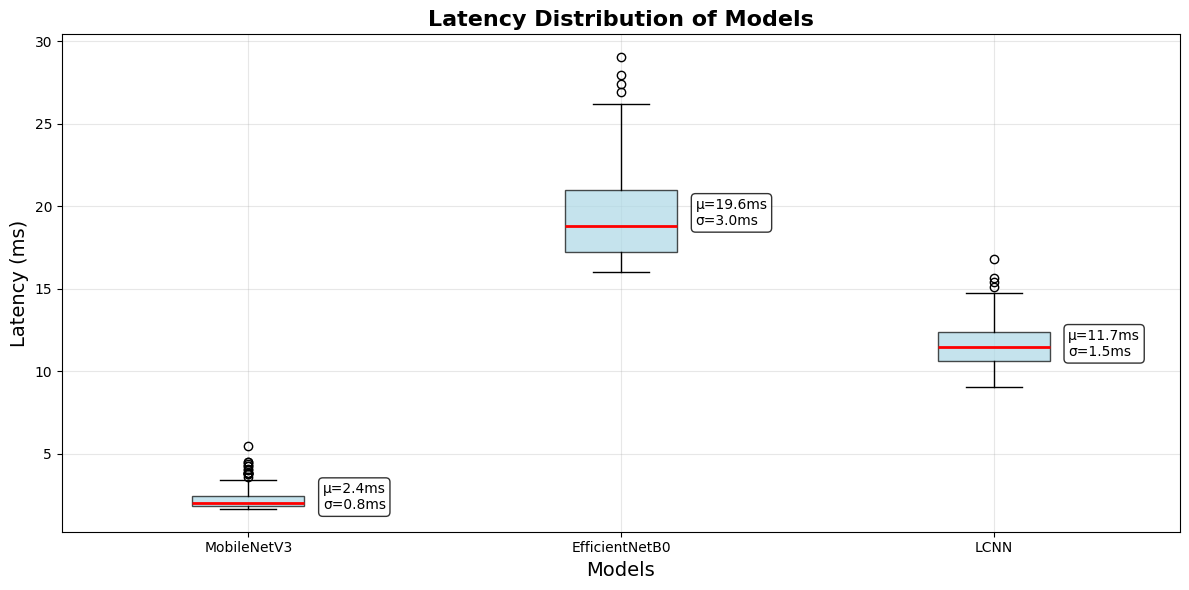

📊 Gráfico salvo como 'latency_distribution.png'


In [16]:
def plot_latency_distribution(results, latencies):
    """Plota a distribuição de latência"""
    plt.figure(figsize=(12, 6))
    
    latency_data = []
    model_names = []
    
    for result in results:
        model_name = result['model_name']
        if model_name in latencies:
            latency_data.append(latencies[model_name])
            model_names.append(model_name)
    
    # Criar boxplot
    box_plot = plt.boxplot(latency_data, labels=model_names, patch_artist=True, 
                          boxprops=dict(facecolor='lightblue', alpha=0.7),
                          medianprops=dict(color='red', linewidth=2))
    
    plt.title('Latency Distribution of Models', fontsize=16, fontweight='bold')
    plt.ylabel('Latency (ms)', fontsize=14)
    plt.xlabel('Models', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=0)
    
    # Adicionar estatísticas
    for i, result in enumerate(results):
        if result['model_name'] in latencies:
            x_pos = i + 1.2 
            y_pos = result['mean_ms']
            
            stats_text = f"μ={result['mean_ms']:.1f}ms\nσ={result['std_ms']:.1f}ms"
            
            plt.text(x_pos, y_pos, stats_text,
                    ha='left', va='center', fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    
    plt.tight_layout()
    plt.savefig('latency_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("📊 Gráfico salvo como 'latency_distribution.png'")

# Execute para plotar
if 'results' in locals() and 'latencies' in locals():
    plot_latency_distribution(results, latencies)
else:
    print("❌ Execute o benchmark ou carregue os resultados primeiro!")

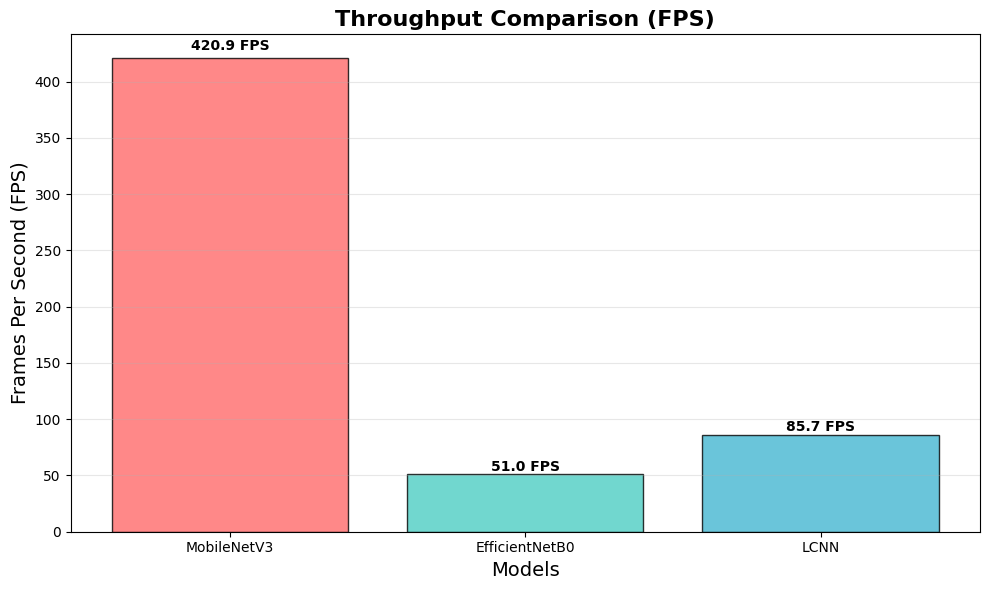

🚀 Gráfico salvo como 'fps_comparison.png'


In [19]:
def plot_fps_comparison(results, show_threshold=False, threshold_fps=30):
    """Plota comparação de FPS"""
    plt.figure(figsize=(10, 6))
    
    model_names = [result['model_name'] for result in results]
    fps_values = [result['fps'] for result in results]
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'][:len(model_names)]
    
    bars = plt.bar(model_names, fps_values, color=colors, alpha=0.8, 
                   edgecolor='black', linewidth=1)
    
    plt.title('Throughput Comparison (FPS)', fontsize=16, fontweight='bold')
    plt.ylabel('Frames Per Second (FPS)', fontsize=14)
    plt.xlabel('Models', fontsize=14)
    plt.grid(True, alpha=0.3, axis='y')
    plt.xticks(rotation=0)
    
    # Adicionar valores nas barras
    for bar, fps in zip(bars, fps_values):
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{fps:.1f} FPS', ha='center', va='bottom', fontweight='bold')
    
    # Linha de threshold para tempo real
    if show_threshold:
        plt.axhline(y=threshold_fps, color='red', linestyle='--', alpha=0.7, linewidth=2)
        plt.text(0.02, threshold_fps + 2, f'Real-time threshold ({threshold_fps} FPS)', 
                transform=plt.gca().get_yaxis_transform(),
                color='red', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('fps_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("🚀 Gráfico salvo como 'fps_comparison.png'")

# Execute para plotar (com ou sem threshold)
if 'results' in locals():
    plot_fps_comparison(results, show_threshold=False, threshold_fps=30)
else:
    print("❌ Execute o benchmark ou carregue os resultados primeiro!")

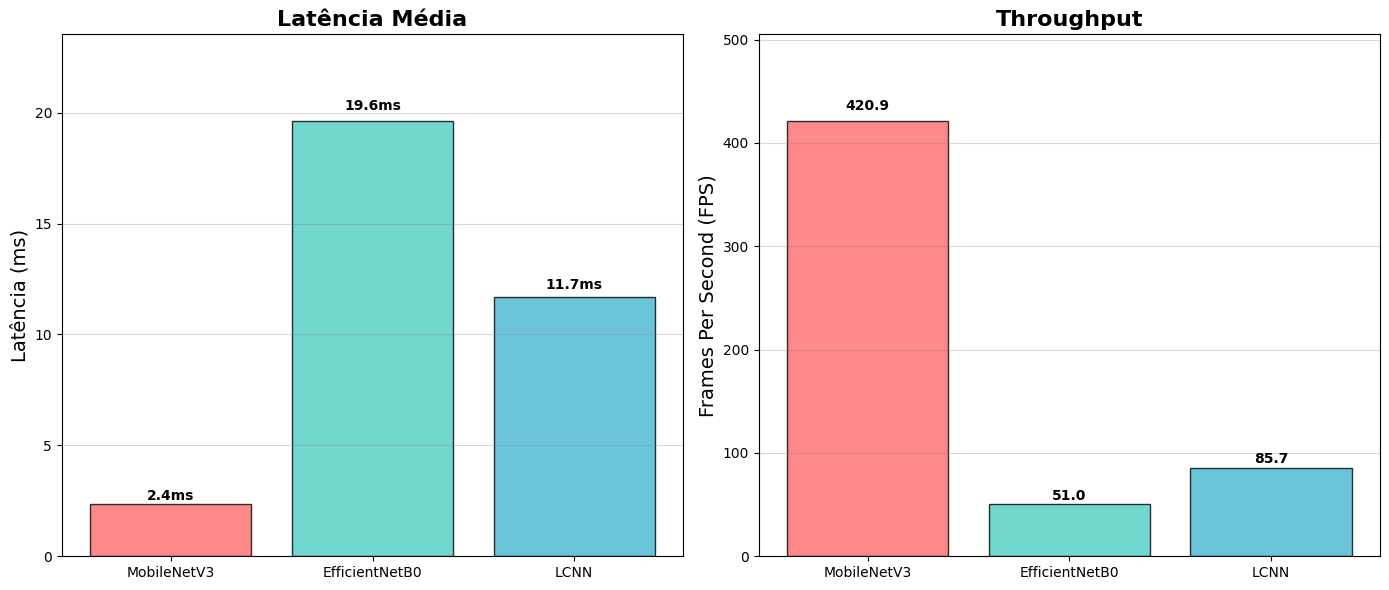

📊 Comparação simples salva como 'simple_comparison.png'


In [20]:
def plot_simple_comparison(results):
    """Plota comparação simples e limpa"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), facecolor='white')
    
    model_names = [result['model_name'] for result in results]
    mean_latencies = [result['mean_ms'] for result in results]
    fps_values = [result['fps'] for result in results]
    
    colors = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4', '#FFEAA7'][:len(model_names)]
    
    # Definir fundo branco
    ax1.set_facecolor('white')
    ax2.set_facecolor('white')
    
    # Gráfico 1: Latência
    bars1 = ax1.bar(model_names, mean_latencies, color=colors, alpha=0.8, 
                    edgecolor='black', linewidth=1)
    ax1.set_title('Latência Média', fontsize=16, fontweight='bold')
    ax1.set_ylabel('Latência (ms)', fontsize=14)
    ax1.grid(True, alpha=0.3, axis='y', color='gray')
    ax1.set_ylim(0, max(mean_latencies) * 1.2)
    
    # Adicionar valores
    for bar, value in zip(bars1, mean_latencies):
        ax1.text(bar.get_x() + bar.get_width()/2., bar.get_height() + bar.get_height()*0.02,
                f'{value:.1f}ms', ha='center', va='bottom', fontweight='bold')
    
    # Gráfico 2: FPS
    bars2 = ax2.bar(model_names, fps_values, color=colors, alpha=0.8, 
                    edgecolor='black', linewidth=1)
    ax2.set_title('Throughput', fontsize=16, fontweight='bold')
    ax2.set_ylabel('Frames Per Second (FPS)', fontsize=14)
    ax2.grid(True, alpha=0.3, axis='y', color='gray')
    ax2.set_ylim(0, max(fps_values) * 1.2)
    
    # Adicionar valores
    for bar, value in zip(bars2, fps_values):
        ax2.text(bar.get_x() + bar.get_width()/2., bar.get_height() + bar.get_height()*0.02,
                f'{value:.1f}', ha='center', va='bottom', fontweight='bold')
    
    plt.tight_layout()
    plt.savefig('simple_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
    plt.show()
    print("📊 Comparação simples salva como 'simple_comparison.png'")

# Execute para plotar versão simples
if 'results' in locals():
    plot_simple_comparison(results)
else:
    print("❌ Execute o benchmark ou carregue os resultados primeiro!")